# Run SCVI With B-Cell Data 
## Import Statements

In [1]:
import scanpy as sc
import sys
sys.path.append("/Users/sarahnarrowedanielsson/Documents/KTH/Exjobb/svci-tools") 
# import hybridvi
import scvi.model as model_
import scvi
# import scvi.module as module
from os import path

import math
import anndata

# matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

import pandas as pd

Global seed set to 0


In [2]:
import matplotlib.colors

cmap_cellcycle = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cellcycle", ["yellow", "green", "magenta", "yellow"], N=128) 

## List of Cell Cycle Genes

In [3]:
# cell cycle genes
cc_mouse = pd.read_csv("data/cc_mouse.csv")
cc_mouse = cc_mouse.iloc[:,1:]
cc_mouse.head()
cell_cycle_genes = [g.upper() for g in cc_mouse["symbol"].tolist()]
print(len(cell_cycle_genes))
print(cell_cycle_genes[:5])

93
['GMNN', 'RAD51', 'CDCA7', 'PRIM1', 'SLBP']


## Get B-Cell Data

In [4]:
### Real data
adata = sc.read("data/small_rna.h5ad")
# fname = "data/classical_filtered_feature_bc_matrix.h5"
# adata = sc.read_10x_h5(fname)
adata.var_names_make_unique()

In [ ]:
####################################################
# Concatenate a list of adatas into one big adata
# def concatenate_adatas(list_adata):
#     return anndata.AnnData.concatenate(*list_adata,batch_key='batch')

In [ ]:
############################ Stewart Data ###########################
# datasets =[
#     "classical",
#     "dn",
#     "HB34",
#     "HB78",
#     "igmmem",
#     "naive",
#     "trans",
# ]

# list_adata=[]
# for i in range(len(datasets)):
#     print(i)
#     fname = "/corgi/cellbuster/stewart2021/processed/"+datasets[i]+"_filtered_feature_bc_matrix.h5"
#     adata = sc.read_10x_h5(fname)
#     adata.var_names_make_unique()
#     adata.obs["dataset"] = datasets[i]
#     adata.obs["tech"] = "3prime"
#     list_adata.append(adata)
    
# adata_stewart = concatenate_adatas(list_adata)


In [5]:
sc.pp.filter_genes(adata, min_counts=3)
adata

AnnData object with n_obs × n_vars = 25109 × 1863
    obs: 'batchname', 'cellbc', 'batch', 'sample_name', 'gc_zone', 'facs_genes', 'method', 'donor', '10xversion', 'trust4_celltype', 'batchnew', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'cellcycle', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

In [6]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

# Restrict to Cell Cycle Genes

In [8]:
adata.var["highly_variable"] = [True if g in cell_cycle_genes else False for g in adata.var.index.tolist()]
adata = adata[:,adata.var["highly_variable"]]
adata

View of AnnData object with n_obs × n_vars = 25109 × 87
    obs: 'batchname', 'cellbc', 'batch', 'sample_name', 'gc_zone', 'facs_genes', 'method', 'donor', '10xversion', 'trust4_celltype', 'batchnew', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'cellcycle', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [9]:
adata = adata.copy()

In [10]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 25109 cells, 87 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/opt/homebrew/anaconda3/envs/scvi_tools/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


In [11]:
model = ""

print(path.exists("saved_model/"))
if (path.exists("saved_model/")):
    model = scvi.model.SCVI("saved_model/", adata, use_gpu=False)
else:
    model = scvi.model.SCVI(adata, n_latent=2)
    model.train()
    model.save("saved_model/")

/Users/sarahnarrowedanielsson/Documents/KTH/Exjobb/scvi-tools/scvi/model/_utils.py:272: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(
/opt/homebrew/anaconda3/envs/scvi_tools/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/opt/homebrew/anaconda3/envs/scvi_tools/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the pr

False
Epoch 2/319:   0%|          | 1/319 [00:02<11:54,  2.25s/it, loss=46.8, v_num=1]

/opt/homebrew/anaconda3/envs/scvi_tools/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1823: LightningDeprecationWarning: `trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7. Use `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(


Epoch 319/319: 100%|██████████| 319/319 [11:29<00:00,  2.16s/it, loss=45.8, v_num=1]


In [12]:
model.get_reconstruction_error()

{'reconstruction_loss': -43.375175937016174}

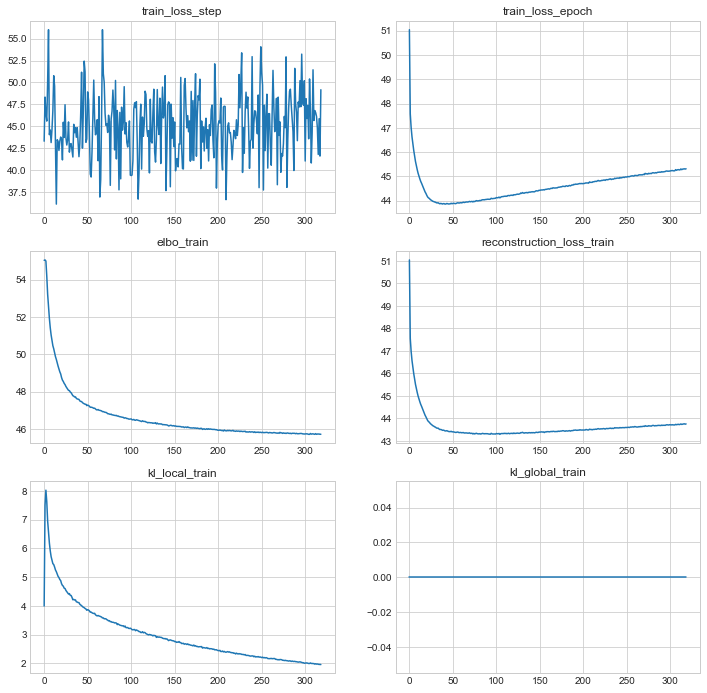

In [13]:
plt.figure(figsize=(12,12))
for i, loss in enumerate(model.history.keys()):
    plt.subplot(3, 2,i+1)
    df = model.history[loss]
    plt.plot(df.iloc[:,0].values)
    plt.title(df.columns.tolist()[0])

In [14]:
latent = model.get_latent_representation()
adata.obsm["scvi"] = latent

In [15]:
adata.obsm["X_pca"] = latent

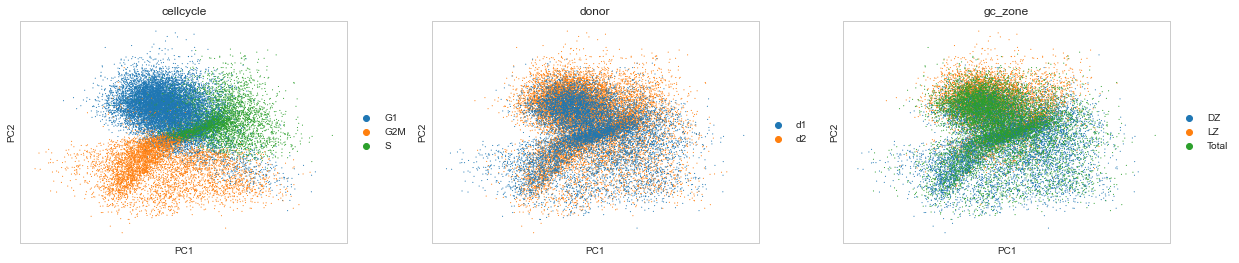

In [16]:
sc.pl.pca(adata, color = ["cellcycle", "donor", "gc_zone"])

# Actual UMAP with PCA Co-ordinates

In [17]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

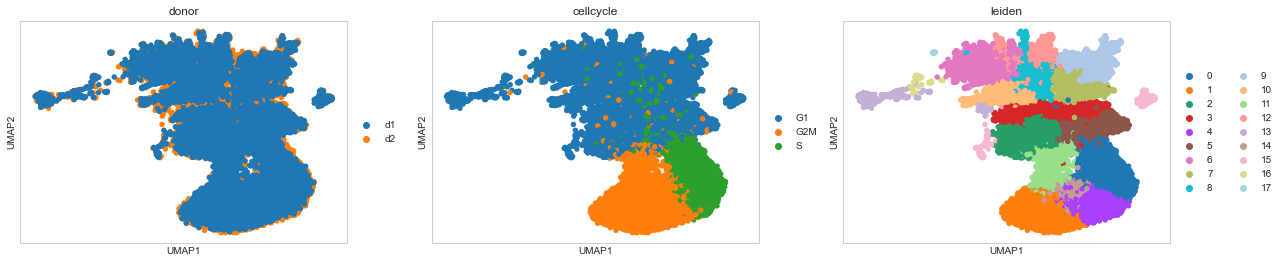

In [18]:
sc.pl.umap(adata, color = ["donor", "cellcycle", "leiden"], size=120)

# Distribution of Latent Space

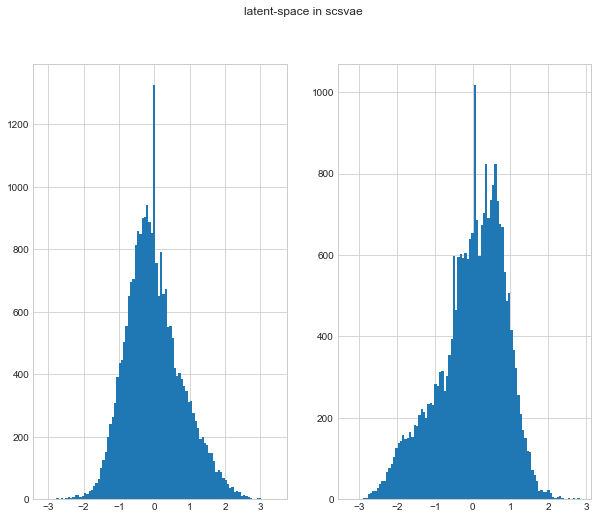

In [19]:
plt.figure(figsize=(10,8))
plt.suptitle("latent-space in scsvae")
plt.subplot(121)
plt.hist(latent[:,0], bins =100)
plt.subplot(122)
plt.hist(latent[:,1], bins =100)
plt.show()

In [20]:
def get_polar(x, y):
        
        r = np.sqrt((x**2)+(y**2))
        theta = np.arctan2(y,x)
        return r, theta
r, theta = get_polar(adata.obsm["scvi"][:,0], adata.obsm["scvi"][:,1])

In [21]:
adata.obs["theta"] = theta

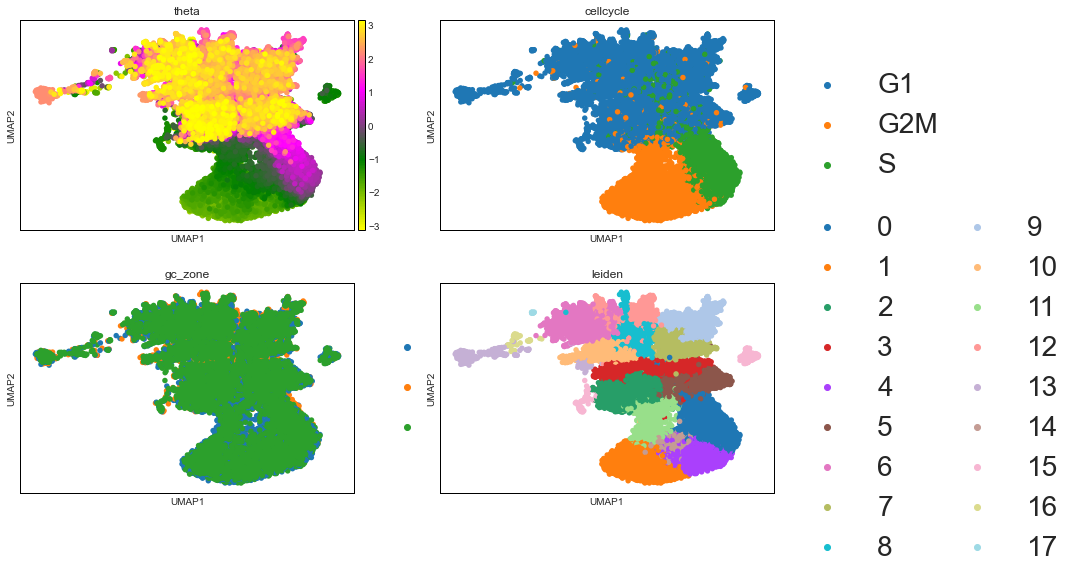

In [22]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['savefig.edgecolor']='black'
plt.rcParams['legend.fontsize']='28'

cmap_cellcycle = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cellcycle", ["yellow", "green", "magenta", "yellow"], N=128)
sc.pl.umap(adata,color=["theta", "cellcycle", "gc_zone", "leiden"], 
           color_map=cmap_cellcycle, ncols=2, size=120)

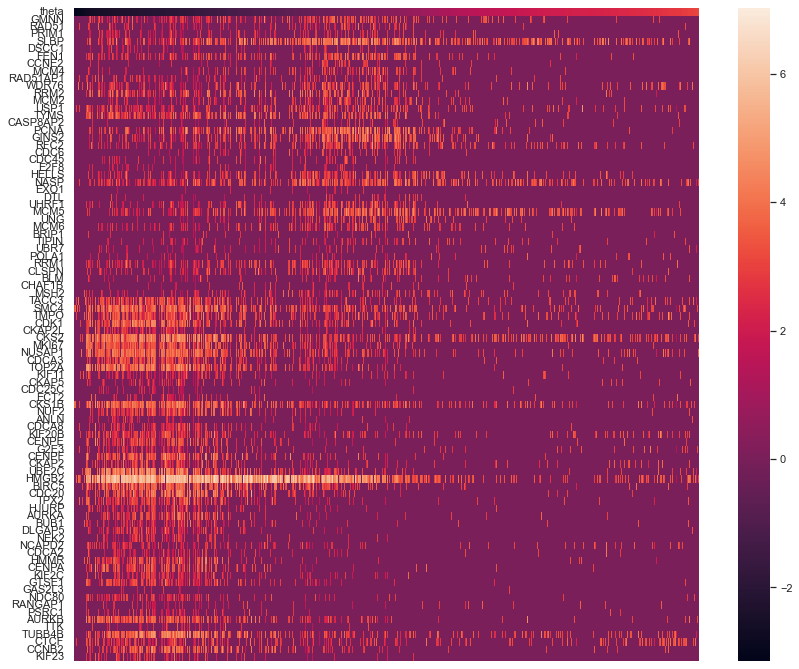

In [23]:
import seaborn as sns
import seaborn as sns; sns.set_theme()
import scipy.stats as ss

def gene_heatmap(adata, theta, genelist):
        plotdata = pd.DataFrame({"theta": theta})
        
        expression_data = adata.X.todense()
        
        for gene in genelist:
            ind = [i for i,v in enumerate(adata.var.index.tolist()) if v == gene]
            if ind:

                expression = expression_data[:,ind[0]]

                plotdata[gene] = expression
        plotdata["theta_rank"] = ss.rankdata(plotdata["theta"].tolist())
        plotdata.sort_values(by=["theta_rank"], inplace = True)
        plotdata.drop(columns=["theta_rank"], inplace=True)
        
        sns.set(font_scale=0.2)
        sns.set(rc={'figure.figsize':(14,12)})

        ax = sns.heatmap(plotdata.T, xticklabels=False, yticklabels=1)
        plt.show()

gene_heatmap(adata, theta, cell_cycle_genes)